In [30]:
import pandas as pd
# import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

from fuzzywuzzy import fuzz

## Anime Data

Load anime and ratings data

In [31]:
anime_filename = '../data/anime.csv'
ratings_filename = '../data/rating.csv'

In [32]:
anime_df = pd.read_csv(anime_filename)
ratings_df = pd.read_csv(ratings_filename)

In [33]:
anime = anime_df.copy()
ratings = ratings_df.copy()

In [11]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [12]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [13]:
anime[anime.isnull().any(axis=1)]

,anime_id,name,genre,type,episodes,rating,members
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607
...,...,...,...,...,...,...,...
12274,34492,Nuki Doki! Tenshi to Akuma no Sakusei Battle -...,Hentai,OVA,Unknown,NaN,392
12279,34491,Sagurare Otome The Animation,Hentai,OVA,1,NaN,79
12280,34312,Saimin Class,Hentai,OVA,Unknown,NaN,240
12282,34388,Shikkoku no Shaga The Animation,Hentai,OVA,Unknown,NaN,195


In [8]:
anime = anime.dropna(subset=['genre','type','rating'])
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12017 non-null  int64  
 1   name      12017 non-null  object 
 2   genre     12017 non-null  object 
 3   type      12017 non-null  object 
 4   episodes  12017 non-null  object 
 5   rating    12017 non-null  float64
 6   members   12017 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 751.1+ KB


Dropping NaN values (only 1% of full data lost)

In [10]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


## Ratings Data

In [11]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [12]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


Frequency of ratings

Text(0, 0.5, 'Titles')

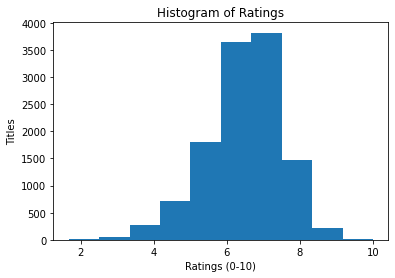

In [13]:
plt.hist(anime.rating)
plt.title("Histogram of Ratings")
plt.xlabel("Ratings (0-10)")
plt.ylabel("Titles")

Ratings by users:

In [16]:
user_ratings = ratings.groupby('user_id').size().reset_index(name='counts').sort_values(by="counts",ascending=False)
user_ratings = user_ratings.set_index('user_id')
user_ratings.head()

,counts
user_id,
48766,10227
42635,3747
53698,2905
57620,2702
59643,2633


In [17]:
user_ratings.counts.mean().round(0)

106.0

The average user rated about 106 titles

Checking if there are duplicate ratings (same user rated a title multiple times)

In [21]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [20]:
ratings.shape

(7813737, 3)

In [24]:
ratings.groupby(['user_id','anime_id']).size()

user_id  anime_id
1        20          1
         24          1
         79          1
         226         1
         241         1
                    ..
73515    16512       1
         17187       1
         22145       1
73516    790         1
         8074        1
Length: 7813730, dtype: int64

In [26]:
user_ratings_cnt = ratings.groupby(['user_id','anime_id']).size().reset_index() 
duplicates = user_ratings_cnt[user_ratings_cnt[0]>1]
duplicates

,user_id,anime_id,0
4499261,42653,1575,2
4499263,42653,2001,2
4499292,42653,11757,2
4499303,42653,16498,2
4499309,42653,20507,2
4499315,42653,22319,2
4499318,42653,23283,2


In [27]:
len(duplicates)

7

In [15]:
# Take the mean of duplicate ratings since there is no timestamp detail for the latest sentiment.

ratings = ratings.groupby(['user_id','anime_id']).mean().reset_index()
ratings.head()

,user_id,anime_id,rating
0,1,20,-1.0
1,1,24,-1.0
2,1,79,-1.0
3,1,226,-1.0
4,1,241,-1.0


In [16]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813730 entries, 0 to 7813729
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   anime_id  int64  
 2   rating    float64
dtypes: float64(1), int64(2)
memory usage: 178.8 MB


---

### Preparing Data

Utility Matrix:

In [17]:
user_anime_mat = ratings.reset_index().pivot(
    index = 'anime_id',
    columns='user_id',
    values='rating'
)

In [18]:
user_anime_mat.fillna(0,inplace=True)

In [24]:
user_anime_mat

user_id,1,2,3,4,5,6,7,8,9,10,...,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
anime_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,10.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,10.0,0.0
6,0.0,0.0,0.0,-1.0,8.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Creating sparse matrix

In [20]:
anime_user_mat_sparse = csr_matrix(user_anime_mat.values)

In [23]:
anime_user_mat_sparse.get_shape()

(11200, 73515)

Creating hashmap for anime titles to match with id/index

In [38]:
anime_titles = anime[['anime_id','name']]
anime_titles

,anime_id,name
0,32281,Kimi no Na wa.
1,5114,Fullmetal Alchemist: Brotherhood
2,28977,Gintama°
3,9253,Steins;Gate
4,9969,Gintama&#039;
...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami
12290,5543,Under World
12291,5621,Violence Gekiga David no Hoshi
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...


In [39]:
# Filtered anime title name key
ind_list = list(user_anime_mat.index)
anime_titles = anime_titles.set_index('anime_id')
anime_titles

,name
anime_id,
32281,Kimi no Na wa.
5114,Fullmetal Alchemist: Brotherhood
28977,Gintama°
9253,Steins;Gate
9969,Gintama&#039;
...,...
9316,Toushindai My Lover: Minami tai Mecha-Minami
5543,Under World
5621,Violence Gekiga David no Hoshi


In [90]:
# ratings_user = ratings.merge(test_anime,left_on='anime_id',right_on='anime_id',how='inner')
# ratings_user

In [40]:
hashmap = {
    anime: i for i, anime in
    enumerate(list(anime_titles.name))
}

In [103]:
hashmap

{'Kimi no Na wa.': 0,
 'Fullmetal Alchemist: Brotherhood': 1,
 'Gintama°': 2,
 'Steins;Gate': 3,
 'Gintama&#039;': 4,
 'Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou': 5,
 'Hunter x Hunter (2011)': 6,
 'Ginga Eiyuu Densetsu': 7,
 'Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare': 8,
 'Gintama&#039;: Enchousen': 9,
 'Clannad: After Story': 10,
 'Koe no Katachi': 11,
 'Gintama': 12,
 'Code Geass: Hangyaku no Lelouch R2': 13,
 'Haikyuu!! Second Season': 14,
 'Sen to Chihiro no Kamikakushi': 15,
 'Shigatsu wa Kimi no Uso': 16,
 'Mushishi Zoku Shou 2nd Season': 17,
 'Ookami Kodomo no Ame to Yuki': 18,
 'Code Geass: Hangyaku no Lelouch': 19,
 'Hajime no Ippo': 20,
 'Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen': 21,
 'Cowboy Bebop': 22,
 'One Punch Man': 23,
 'Mononoke Hime': 24,
 'Suzumiya Haruhi no Shoushitsu': 25,
 'Monogatari Series: Second Season': 26,
 'Mushishi Zoku Shou': 27,
 'Mushishi': 28,
 'Tengen Toppa Gurren Lagann': 29,
 'Great Teacher Onizuka': 30,
 '

### KNN Clustering

In [ ]:
# Fuzzy matching (title names)

match_tuple = []
# get match
for title, idx in hashmap.items():
    ratio = fuzz.ratio(title.lower(), fav_movie.lower())
    if ratio >= 60:
        match_tuple.append((title, idx, ratio))
# sort
match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
if not match_tuple:
    print('Oops! No match is found')
else:
    print('Found possible matches in our database: '
          '{0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [109]:
match_tuple = []

In [114]:
fav_anime = 'mushishi'

In [115]:
for title,idx in hashmap.items():
    ratio = fuzz.ratio(title.lower(), fav_anime.lower())
    if ratio >= 60:
        match_tuple.append((title,idx,ratio))

In [116]:
match_tuple = sorted(match_tuple,key=lambda x: x[2])[::-1]

In [117]:
match_tuple

[('Mushishi', 28, 100),
 ('Sushi Azarashi', 10399, 64),
 ('Shiki', 541, 62),
 ('Mushishi Zoku Shou', 27, 62),
 ('Kuroshitsuji', 458, 60)]

In [120]:
if not match_tuple:
    print('No match found.')
else:
    print('Found possible matches in database: {0}'.format(x[0] for x in match_tuple))
    print(match_tuple[0][1])

Found possible matches in database: <generator object <genexpr> at 0x12a16c580>
28


In [138]:
def fuzzy_match(hash_dict,anime_string):
    match_tuple = []
    
    for title,idx in hashmap.items():
        ratio = fuzz.ratio(title.lower(), anime_string.lower())
        if ratio >= 60:
            match_tuple.append((title,idx,ratio))
    
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    
    if not match_tuple:
        print('No match found.')
    else:
        print('Found possible matches in database: {0}'.format(x[0] for x in match_tuple))
        return match_tuple[0][1]

In [139]:
fuzzy_match(hashmap,'ushishi')

Found possible matches in database: <generator object fuzzy_match.<locals>.<genexpr> at 0x12a699dd0>


28

### Inferences

In [123]:
model = NearestNeighbors()

In [27]:
model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [28]:
model.fit(anime_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [29]:
idx = fuzzy_match(hashmap, 'naruto')

NameError: name 'fuzzy_match' is not defined

In [141]:
idx

841

In [142]:
distance,indices = model.kneighbors(anime_user_mat_sparse[idx],n_neighbors=10+1)

In [143]:
distance

array([[ 0.        , 47.69696007, 52.53570215, 55.13619501, 55.73149917,
        55.75840744, 55.75840744, 55.76737397, 55.83905443, 55.96427432,
        55.99107072]])

In [144]:
indices

array([[ 841, 2538, 2537, 2007, 6010, 6505, 5535,  990, 2113, 6351, 7525]])

In [145]:
indices.squeeze()

array([ 841, 2538, 2537, 2007, 6010, 6505, 5535,  990, 2113, 6351, 7525])

In [149]:
raw_recommends = sorted(
                    list(
                        zip(indices.squeeze().tolist(), distance.squeeze().tolist())
                    ),
                    key=lambda x: x[1])[:0:-1]

In [150]:
raw_recommends

[(7525, 55.991070716677676),
 (6351, 55.96427431853289),
 (2113, 55.839054433254866),
 (990, 55.767373974394744),
 (5535, 55.758407437802596),
 (6505, 55.758407437802596),
 (6010, 55.731499172371095),
 (2007, 55.136195008360886),
 (2537, 52.53570214625479),
 (2538, 47.69696007084728)]

In [151]:
reverse_hashmap = {v: k for k, v in hashmap.items()}

In [152]:
for i, (idx, dist) in enumerate(raw_recommends):
    print('{0}: {1}, with distance '
          'of {2}'.format(i+1, reverse_hashmap[idx], dist))

1: Ark IX, with distance of 55.991070716677676
2: Hajimari no Boukensha-tachi: Legend of Crystania, with distance of 55.96427431853289
3: Kinnikuman, with distance of 55.839054433254866
4: UN-GO: Inga-ron, with distance of 55.767373974394744
5: Yoshimune, with distance of 55.758407437802596
6: GAME OVER feat. Hatsune Miku, with distance of 55.758407437802596
7: RG Veda, with distance of 55.731499172371095
8: Kuruneko Season 2, with distance of 55.136195008360886
9: Urayasu Tekkin Kazoku, with distance of 52.53570214625479
10: Wasurenagumo, with distance of 47.69696007084728


In [ ]:
# https://github.com/KevinLiao159/MyDataSciencePortfolio/blob/master/movie_recommender/src/knn_recommender.py

In [57]:
def _fuzzy_match(hash_dict,fav_anime):
    match_tuple = []

    for title, idx in hash_dict.items():
        ratio = fuzz.ratio(title.lower(), fav_anime.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))

    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    
#     print(match_tuple)
#     return match_tuple
    if not match_tuple:
        print('No match found.')
    else:
        print('Found possible matches in database: {0}'.format([x[0] for x in match_tuple]))
        return match_tuple[0][1]

In [58]:
_fuzzy_match(hashmap,'Naruto')

Found possible matches in database: ['Naruto', 'Naruto x UT', 'Haruwo', 'Nayuta']


841

In [52]:
test[0][0]

'Naruto'

In [56]:
[x[0] for x in test]

['Naruto', 'Naruto x UT', 'Haruwo', 'Nayuta']

Break anime dataframe by tokenizing genre and type (get rid of name, episodes, rating, members)

In [ ]:
anime_genre_type = pd.concat([anime,anime['type'].str.get_dummies(),anime['genre'].str.get_dummies(sep=',')],axis=1)

In [ ]:
anime_genre_type.head()

In [ ]:
anime_genre_type.columns

In [ ]:
anime_genre_type.drop(columns=['genre','type','episodes','members'])

In [6]:
import os

In [7]:
def find():
    spark_home = os.environ.get('SPARK_HOME', None)

    if not spark_home:
        for path in [
            '/usr/local/opt/apache-spark/libexec', # OS X Homebrew
            '/usr/lib/spark/' # AWS Amazon EMR
            # Any other common places to look?
        ]:
            if os.path.exists(path):
                spark_home = path
                break

    if not spark_home:
        raise ValueError("Couldn't find Spark, make sure SPARK_HOME env is set"
                         " or Spark is in an expected location (e.g. from homebrew installation).")

    return spark_home

In [8]:
find()

'/opt/spark'